In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# Data Ingestion

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
# setting up AWS credentials

aws_access_key = "your-access-key"
aws_secret_key = "your-secret-key"

spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", aws_access_key)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", aws_secret_key)



In [0]:
# Script to get list of files from s3 path

import boto3

# Initialize a session using boto3
s3 = boto3.client(
    's3',
    aws_access_key_id = aws_access_key,
    aws_secret_access_key = aws_secret_key
)

bucket_name = 'azeem-spark-bucket'
prefix = "IPL/Raw Match Data/" # for folder-like structure or specific files, otherwise leave empty

# Function to list all objects with pagination
def list_all_objects(bucket_name, prefix):
    files = []
    continuation_token = None

    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

        if 'Contents' in response:
            for obj in response['Contents']:
                files.append(obj['Key'])

        # Check if there are more files to fetch
        if response.get('IsTruncated'):  # If IsTruncated is True, there are more files to fetch
            continuation_token = response['NextContinuationToken']
        else:
            break

    return files

# List all files in the bucket
all_files = list_all_objects(bucket_name, prefix)
print(all_files)


['IPL/Raw Match Data/', 'IPL/Raw Match Data/1082591.csv', 'IPL/Raw Match Data/1082591_info.csv', 'IPL/Raw Match Data/1082592.csv', 'IPL/Raw Match Data/1082592_info.csv', 'IPL/Raw Match Data/1082593.csv', 'IPL/Raw Match Data/1082593_info.csv', 'IPL/Raw Match Data/1082594.csv', 'IPL/Raw Match Data/1082594_info.csv', 'IPL/Raw Match Data/1082595.csv', 'IPL/Raw Match Data/1082595_info.csv', 'IPL/Raw Match Data/1082596.csv', 'IPL/Raw Match Data/1082596_info.csv', 'IPL/Raw Match Data/1082597.csv', 'IPL/Raw Match Data/1082597_info.csv', 'IPL/Raw Match Data/1082598.csv', 'IPL/Raw Match Data/1082598_info.csv', 'IPL/Raw Match Data/1082599.csv', 'IPL/Raw Match Data/1082599_info.csv', 'IPL/Raw Match Data/1082600.csv', 'IPL/Raw Match Data/1082600_info.csv', 'IPL/Raw Match Data/1082601.csv', 'IPL/Raw Match Data/1082601_info.csv', 'IPL/Raw Match Data/1082602.csv', 'IPL/Raw Match Data/1082602_info.csv', 'IPL/Raw Match Data/1082603.csv', 'IPL/Raw Match Data/1082603_info.csv', 'IPL/Raw Match Data/1082604

In [0]:
# Filter files for ball by ball data(without "_info" in filename)
main_files = [file for file in all_files if file.endswith('.csv') and '_info' not in file]

# Filter files with "_info" in filename
info_files = [file for file in all_files if file.endswith('_info.csv')]



In [0]:
# Schema for ball by ball data

ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("season", StringType(), True),
    StructField("start_date", DateType(), True),
    StructField("venue", StringType(), True),
    StructField("innings", IntegerType(), True),
    StructField("ball", DoubleType(), True),
    StructField("batting_team", StringType(), True),
    StructField("bowling_team", StringType(), True),
    StructField("striker", StringType(), True),
    StructField("non_striker", StringType(), True),
    StructField("bowler", StringType(), True),
    StructField("runs_off_bat", IntegerType(), True),
    StructField("extras", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("wicket_type", StringType(), True),
    StructField("player_dismissed", StringType(), True),
    StructField("other_wicket_type", StringType(), True),
    StructField("other_player_dismissed", StringType(), True)
])


In [0]:
# Read ball by ball data for all matches

ball_by_ball_df = spark.read.option("header","True").schema(ball_by_ball_schema).csv([f"s3://{bucket_name}/{file}" for file in main_files]).cache()

In [0]:
ball_by_ball_df.count()

Out[8]: 260920

In [0]:
ball_by_ball_df.show(5, truncate = False)

+--------+------+----------+---------------------------------------------------------------------+-------+----+---------------------------+--------------------+-------+------------+---------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+
|match_id|season|start_date|venue                                                                |innings|ball|batting_team               |bowling_team        |striker|non_striker |bowler   |runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|
+--------+------+----------+---------------------------------------------------------------------+-------+----+---------------------------+--------------------+-------+------------+---------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+
|1359517 |2023  |2023-05-01|Bharat Ratna Shri Ata

In [0]:
# Temporary schema to read data from info files

match_info_schema = StructType([
    StructField("c1", StringType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
    StructField("c4", StringType(), True),
    StructField("c5", StringType(), True)
])

In [0]:
# read data from info files
match_df = spark.read.schema(match_info_schema).csv([f"s3://{bucket_name}/{file}" for file in info_files])

# add input_file_name to extract match_id from filename
match_df = match_df.withColumn("filename",input_file_name()).cache()

In [0]:
match_df.count()

Out[12]: 77266

In [0]:
match_df.show(50, truncate = False)

+-------+---------------+---------------------------------------------------------------------+---------------+--------+---------------------------------------------------------------+
|c1     |c2             |c3                                                                   |c4             |c5      |filename                                                       |
+-------+---------------+---------------------------------------------------------------------+---------------+--------+---------------------------------------------------------------+
|version|2.2.0          |null                                                                 |null           |null    |s3://azeem-spark-bucket/IPL/Raw%20Match%20Data/1426292_info.csv|
|info   |balls_per_over |6                                                                    |null           |null    |s3://azeem-spark-bucket/IPL/Raw%20Match%20Data/1426292_info.csv|
|info   |team           |Kolkata Knight Riders                             

# Data Cleansing & Transformation

In [0]:
# extract match_id and drop filename column

match_df = match_df.withColumn("match_id",split(split(col("filename"),"/")[5],"_")[0]).drop("filename")

match_df.show(50, truncate = False)

+-------+---------------+---------------------------------------------------------------------+---------------+--------+--------+
|c1     |c2             |c3                                                                   |c4             |c5      |match_id|
+-------+---------------+---------------------------------------------------------------------+---------------+--------+--------+
|version|2.2.0          |null                                                                 |null           |null    |1426292 |
|info   |balls_per_over |6                                                                    |null           |null    |1426292 |
|info   |team           |Kolkata Knight Riders                                                |null           |null    |1426292 |
|info   |team           |Lucknow Super Giants                                                 |null           |null    |1426292 |
|info   |gender         |male                                                             

In [0]:
# reorder data

match_df = match_df.select("match_id","c1","c2","c3","c4","c5")

match_df.show(50, truncate = False)

+--------+-------+---------------+---------------------------------------------------------------------+---------------+--------+
|match_id|c1     |c2             |c3                                                                   |c4             |c5      |
+--------+-------+---------------+---------------------------------------------------------------------+---------------+--------+
|1426292 |version|2.2.0          |null                                                                 |null           |null    |
|1426292 |info   |balls_per_over |6                                                                    |null           |null    |
|1426292 |info   |team           |Kolkata Knight Riders                                                |null           |null    |
|1426292 |info   |team           |Lucknow Super Giants                                                 |null           |null    |
|1426292 |info   |gender         |male                                                    

match_df contains data related to match, players in each team, and registry for each player with a unique player code. We can extract data for each of these categories by applying filter on column "c2"

In [0]:
# Filter out rows where the key is 'player' or 'registry' to get match related data
match_info_df = match_df.filter((col("c2") != "player") & (col("c2") != "registry") & (col("c1") != "version"))

#select columns match_id, c2(key) and c3(value)
match_info_df = match_info_df.select("match_id","c2","c3")


match_info_df.show(50, truncate = False)

+--------+---------------+---------------------------------------------------------------------+
|match_id|c2             |c3                                                                   |
+--------+---------------+---------------------------------------------------------------------+
|1426292 |balls_per_over |6                                                                    |
|1426292 |team           |Kolkata Knight Riders                                                |
|1426292 |team           |Lucknow Super Giants                                                 |
|1426292 |gender         |male                                                                 |
|1426292 |season         |2024                                                                 |
|1426292 |date           |2024/05/05                                                           |
|1426292 |event          |Indian Premier League                                                |
|1426292 |match_number   |54  

In [0]:
from pyspark.sql import Window

In [0]:
# Script to separate 2 teams of the match into team_1 and team_2

# Filter rows where c2 == 'team'
team_rows = match_info_df.filter(col("c2") == "team")

# Assign row numbers to 'team' rows within each match_id
window_spec = Window.partitionBy("match_id").orderBy("match_id")
team_rows = team_rows.withColumn("team_number", row_number().over(window_spec))


# Update c2 based on the row number
team_rows = team_rows.withColumn(
    "updated_c2", 
    when(col("team_number") == 1, "team_1")
    .when(col("team_number") == 2, "team_2")
    .otherwise(col("c2"))
)

# Drop the extra column "team_number"
team_rows = team_rows.drop("team_number")

# Step 5: Join the updated team rows with the original dataframe
updated_df = match_info_df.join(
    broadcast(team_rows), 
    ["match_id", "c2","c3"],
    "left")

# Update team names with updated values
updated_df = updated_df.withColumn(
    "c2", 
    when(col("c2") == "team", col("updated_c2"))
    .otherwise(col("c2"))
)

match_info_df = updated_df.drop("updated_c2")

In [0]:
# Similar script to update umpire values to "umpire_1" & "umpire_2"

umpire_rows = match_info_df.filter(col("c2") == "umpire")

umpire_rows = umpire_rows.withColumn("umpire_number", row_number().over(window_spec))


umpire_rows = umpire_rows.withColumn(
    "updated_c2", 
    when(col("umpire_number") == 1, "umpire_1")
    .when(col("umpire_number") == 2, "umpire_2")
    .otherwise(col("c2"))
)

umpire_rows = umpire_rows.drop("umpire_number")


updated_df = match_info_df.join(
    broadcast(umpire_rows), 
    ["match_id", "c2","c3"],
    "left")

updated_df = updated_df.withColumn(
    "c2", 
    when(col("c2") == "umpire", col("updated_c2"))
    .otherwise(col("c2"))
)

match_info_df = updated_df.drop("updated_c2")

match_info_df.show(50, truncate=False)

+--------+---------------+---------------------------------------------------------------------+
|match_id|c2             |c3                                                                   |
+--------+---------------+---------------------------------------------------------------------+
|1426292 |balls_per_over |6                                                                    |
|1426292 |team_1         |Kolkata Knight Riders                                                |
|1426292 |team_2         |Lucknow Super Giants                                                 |
|1426292 |gender         |male                                                                 |
|1426292 |season         |2024                                                                 |
|1426292 |date           |2024/05/05                                                           |
|1426292 |event          |Indian Premier League                                                |
|1426292 |match_number   |54  

In [0]:
# Replacing "eliminator" with "super_over_winner" to indicate winner of tied match

match_info_df = match_info_df.withColumn(
    "c2",
    when((col("c2") == "eliminator"), "super_over_winner")
    .otherwise(col("c2"))
)

In [0]:
# Pivot the data to make it columnar with 1 row for each match
match_info_df = match_info_df.groupBy("match_id").pivot("c2").agg(first("c3")).cache()


In [0]:
match_info_df.count()

Out[22]: 1095

In [0]:
# Final DataFrame for match_info
match_info_df.show(10, truncate = False)

+--------+--------------+------------+----------+---------------------+------+------------+---------------+------+-------+---------------+---------------------+-------+-----------------+---------------------------+---------------------------+-------------+---------------------------+---------------+---------------------+-------------+---------------------------------------------------------------------+---------------------------+-----------+--------------+
|match_id|balls_per_over|city        |date      |event                |gender|match_number|match_referee  |method|outcome|player_of_match|reserve_umpire       |season |super_over_winner|team_1                     |team_2                     |toss_decision|toss_winner                |tv_umpire      |umpire_1             |umpire_2     |venue                                                                |winner                     |winner_runs|winner_wickets|
+--------+--------------+------------+----------+---------------------+-----

In [0]:
# Dataframe for team and player list for each match
match_players_df = match_df.filter((col("c2") == "player"))

# selecting match_id, c3(team name), c4(player names)
match_players_df = match_players_df.select("match_id","c3","c4")

# Renaming columns
match_players_df = match_players_df.withColumnRenamed("c3","team").withColumnRenamed("c4","player")

# updating team name to a standard format

match_players_df = match_players_df.withColumn(
    "team",
    when((col("team") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("team") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("team"))).cache()


match_players_df.count()

Out[24]: 24367

In [0]:
# Final Dataframe for match_players
match_players_df.show(100)

+--------+--------------------+-----------------+
|match_id|                team|           player|
+--------+--------------------+-----------------+
| 1426292|Kolkata Knight Ri...|         VG Arora|
| 1426292|Kolkata Knight Ri...|          PD Salt|
| 1426292|Kolkata Knight Ri...|        SP Narine|
| 1426292|Kolkata Knight Ri...|    A Raghuvanshi|
| 1426292|Kolkata Knight Ri...|       AD Russell|
| 1426292|Kolkata Knight Ri...|         RK Singh|
| 1426292|Kolkata Knight Ri...|          SS Iyer|
| 1426292|Kolkata Knight Ri...|  Ramandeep Singh|
| 1426292|Kolkata Knight Ri...|          VR Iyer|
| 1426292|Kolkata Knight Ri...|         MA Starc|
| 1426292|Kolkata Knight Ri...|     Harshit Rana|
| 1426292|Kolkata Knight Ri...|         CV Varun|
| 1426292|Lucknow Super Giants|      Yash Thakur|
| 1426292|Lucknow Super Giants|      Mohsin Khan|
| 1426292|Lucknow Super Giants|         KL Rahul|
| 1426292|Lucknow Super Giants|      AA Kulkarni|
| 1426292|Lucknow Super Giants|       MP Stoinis|


In [0]:
# Dataframe for player and their unique player code
player_registry_df = match_df.filter((col("c2") == "registry"))

# selecting c4(player names), c5(player code)
player_registry_df = player_registry_df.select("c4","c5")

# Renaming columns
player_registry_df = player_registry_df.withColumnRenamed("c4","player").withColumnRenamed("c5","player_code")


player_registry_df.count()

Out[26]: 29985

In [0]:
# group by 'player' and aggregate to create table with unique row for each player
player_registry_df = player_registry_df.groupBy("player").agg(first("player_code").alias("player_code")).cache()

player_registry_df.count()

Out[27]: 883

In [0]:
# Final Dataframe for player_registry
player_registry_df.show(100, truncate = False)

+----------------+-----------+
|player          |player_code|
+----------------+-----------+
|BK Ravi         |ff8c3cfb   |
|Kuldeep Yadav   |8d2c70ad   |
|S Anirudha      |95a2ea61   |
|TM Dilshan      |5bdcdb72   |
|J Botha         |7c503806   |
|KA Pollard      |a757b0d8   |
|LA Carseldine   |d872f52a   |
|M Muralitharan  |4ba44e19   |
|M Theekshana    |f24c6701   |
|RE Koertzen     |0265fab2   |
|J Little        |9061a703   |
|Bhavesh Patel   |ee03dc30   |
|SJ Davis        |bc71b0b2   |
|SS Cottrell     |a1d053dd   |
|CA Ingram       |c995d726   |
|R Sanjay Yadav  |33ffc3dd   |
|DR Smith        |35205dfc   |
|Jaskaran Singh  |d7b3a420   |
|A Flintoff      |ddc0828d   |
|D Govindjee     |8b4c4069   |
|M Manhas        |c42aaf71   |
|MSS Ranawat     |8048c698   |
|Yash Thakur     |4b31f3a3   |
|A Bengeri       |c109497d   |
|GR Napier       |611926bc   |
|A Mukund        |6165bca6   |
|AR Patel        |2e171977   |
|B Lee           |dd09ff8e   |
|BMAJ Mendis     |9868bc75   |
|D du Pr

In [0]:
# removing match_df from memory as its no longer needed

match_df.unpersist(blocking = True)

Out[31]: DataFrame[match_id: string, c1: string, c2: string, c3: string, c4: string, c5: string]

Cleansing & Transformation for match_info_df -->

In [0]:
# updating season to a standard format

match_info_df = match_info_df.withColumn(
    "season",
    when((col("season") == "2007/08"), "2008")
    .when((col("season") == "2009/10"), "2010")
    .when((col("season") == "2020/21"), "2020")
    .otherwise(col("season"))
)



In [0]:
# updating team name to a standard format

match_info_df = match_info_df.withColumn(
    "team_1",
    when((col("team_1") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("team_1") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("team_1"))).withColumn(
    "team_2",
    when((col("team_2") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("team_2") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("team_2"))).withColumn(
    "super_over_winner",
    when((col("super_over_winner") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("super_over_winner") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("super_over_winner"))).withColumn(
    "toss_winner",
    when((col("toss_winner") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("toss_winner") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("toss_winner"))).withColumn(
    "winner",
    when((col("winner") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("winner") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("winner")))


In [0]:
# Script to update match_number for playoff matches based on season

window_spec = Window.partitionBy("season").orderBy("season","date")

# Filtering matched where match number is null as these are playoff matches
playoffs_df = match_info_df.filter(col("match_number").isNull()).select("match_id","season","date","match_number")

playoffs_df = playoffs_df.withColumn("game_number", row_number().over(window_spec))

playoffs_df = playoffs_df.withColumn(
    "updated_match_number",
    when(col("season").isin("2008","2009"),
         when(col("game_number") == 1, "Semi-Final 1")
         .when(col("game_number") == 2, "Semi-Final 2")
         .when(col("game_number") == 3, "Final")
         )
    .when(col("season") == "2010",
         when(col("game_number") == 1, "Semi-Final 1")
         .when(col("game_number") == 2, "Semi-Final 2")
         .when(col("game_number") == 3, "3rd Place Play-off")
         .when(col("game_number") == 4, "Final")
         )
    .otherwise(
         when(col("game_number") == 1, "Qualifier 1")
         .when(col("game_number") == 2, "Eliminator")
         .when(col("game_number") == 3, "Qualifier 2")
         .when(col("game_number") == 4, "Final")
    )
)


playoffs_df = playoffs_df.drop("game_number")

updated_df = match_info_df.join(
    broadcast(playoffs_df.select("match_id","season","date","updated_match_number")), #excluding match_number as its null
    ["match_id","season","date"],
    "left"
)

updated_df = updated_df.withColumn(
    "match_number", 
    when(col("match_number").isNull(), col("updated_match_number"))
    .otherwise(col("match_number"))
)

match_info_df = updated_df.drop("updated_match_number")

In [0]:
# adding match_type column to distinguish league and playoff games

match_info_df = match_info_df.withColumn(
    "match_type",
    when(col("match_number").isin("Semi-Final 1","Semi-Final 2","3rd Place Play-off","Qualifier 1","Qualifier 2","Eliminator","Final"),"Playoffs")
    .otherwise("League")
)

In [0]:
# Final Dataframe for match_info

match_info_df.show(10, truncate = False)

+--------+------+----------+--------------+------------+---------------------+------+------------+---------------+------+-------+---------------+---------------------+-----------------+---------------------------+---------------------------+-------------+---------------------------+---------------+---------------------+-------------+---------------------------------------------------------------------+---------------------------+-----------+--------------+----------+
|match_id|season|date      |balls_per_over|city        |event                |gender|match_number|match_referee  |method|outcome|player_of_match|reserve_umpire       |super_over_winner|team_1                     |team_2                     |toss_decision|toss_winner                |tv_umpire      |umpire_1             |umpire_2     |venue                                                                |winner                     |winner_runs|winner_wickets|match_type|
+--------+------+----------+--------------+------------+

Cleansing & Transformation for ball_by_ball_df -->

In [0]:
# updating season to a standard format

ball_by_ball_df = ball_by_ball_df.withColumn(
    "season",
    when((col("season") == "2007/08"), "2008")
    .when((col("season") == "2009/10"), "2010")
    .when((col("season") == "2020/21"), "2020")
    .otherwise(col("season"))
)

In [0]:
# updating team name to a standard format

ball_by_ball_df = ball_by_ball_df.withColumn(
    "batting_team",
    when((col("batting_team") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("batting_team") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("batting_team"))).withColumn(
    "bowling_team",
    when((col("bowling_team") == "Royal Challengers Bangalore"), "Royal Challengers Bengaluru")
    .when((col("bowling_team") == "Rising Pune Supergiants"), "Rising Pune Supergiant")
    .otherwise(col("bowling_team")))


In [0]:
#Replacing null values with integer value

ball_by_ball_df = ball_by_ball_df.fillna(0,["runs_off_bat","extras","wides","noballs","byes","legbyes","penalty"])

ball_by_ball_df.show(5)

+--------+------+----------+--------------------+-------+----+--------------------+--------------------+-------+------------+---------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+
|match_id|season|start_date|               venue|innings|ball|        batting_team|        bowling_team|striker| non_striker|   bowler|runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|
+--------+------+----------+--------------------+-------+----+--------------------+--------------------+-------+------------+---------+------------+------+-----+-------+----+-------+-------+-----------+----------------+-----------------+----------------------+
| 1359517|  2023|2023-05-01|Bharat Ratna Shri...|      1| 0.1|Royal Challengers...|Lucknow Super Giants|V Kohli|F du Plessis|KH Pandya|           4|     0|    0|      0|   0|      0|      0|       null|            nul

In [0]:
# adding column for total wicket taken on each ball

ball_by_ball_df = ball_by_ball_df.withColumn(
    "wickets_taken",
    when(col("wicket_type").isNotNull(), lit(1)).otherwise(lit(0)) + when(col("other_wicket_type").isNotNull(), lit(1)).otherwise(lit(0)) 
    )



In [0]:
#Splitting ball column into over and ball_no

ball_by_ball_df = ball_by_ball_df.withColumn("over",split(col("ball"),"\.")[0]).withColumn("ball_no",split(col("ball"),"\.")[1])

ball_by_ball_df = ball_by_ball_df.drop("ball").withColumnRenamed("ball_no","ball")

In [0]:
# adding column for total runs scored on a ball

ball_by_ball_df = ball_by_ball_df.withColumn("runs_scored",col("runs_off_bat")+col("extras"))

In [0]:
# changing datatype of columns season, over, ball

ball_by_ball_df = ball_by_ball_df.withColumn("season",col("season").cast(IntegerType())) \
.withColumn("over",col("over").cast(IntegerType())) \
.withColumn("ball",col("ball").cast(IntegerType()))


In [0]:
# display the changed datatype in schema

ball_by_ball_df.printSchema()

root
 |-- match_id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- start_date: date (nullable = true)
 |-- venue: string (nullable = true)
 |-- innings: integer (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)
 |-- striker: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs_off_bat: integer (nullable = true)
 |-- extras: integer (nullable = true)
 |-- wides: integer (nullable = true)
 |-- noballs: integer (nullable = true)
 |-- byes: integer (nullable = true)
 |-- legbyes: integer (nullable = true)
 |-- penalty: integer (nullable = true)
 |-- wicket_type: string (nullable = true)
 |-- player_dismissed: string (nullable = true)
 |-- other_wicket_type: string (nullable = true)
 |-- other_player_dismissed: string (nullable = true)
 |-- wickets_taken: integer (nullable = false)
 |-- over: integer (nullable = true)
 |-- ball: integer (nullable = tr

In [0]:
# Window Function: Calculate running total of runs & wickets in each match & innings 

windowSpec = Window.partitionBy("match_id","innings").orderBy("over","ball")

ball_by_ball_df = ball_by_ball_df.withColumn(
    "running_total_runs",
    sum("runs_scored").over(windowSpec)
).withColumn(
    "running_total_wickets",
    sum("wickets_taken").over(windowSpec)
)

In [0]:
#sample match with running total and wickets

ball_by_ball_df.filter(col("match_id") == "1082591").select("innings","over","ball","runs_scored","running_total_runs","wickets_taken","running_total_wickets").orderBy("innings","over","ball").show(150)

+-------+----+----+-----------+------------------+-------------+---------------------+
|innings|over|ball|runs_scored|running_total_runs|wickets_taken|running_total_wickets|
+-------+----+----+-----------+------------------+-------------+---------------------+
|      1|   0|   1|          0|                 0|            0|                    0|
|      1|   0|   2|          0|                 0|            0|                    0|
|      1|   0|   3|          4|                 4|            0|                    0|
|      1|   0|   4|          0|                 4|            0|                    0|
|      1|   0|   5|          2|                 6|            0|                    0|
|      1|   0|   6|          0|                 6|            0|                    0|
|      1|   0|   7|          1|                 7|            0|                    0|
|      1|   1|   1|          1|                 8|            0|                    0|
|      1|   1|   2|          4|            

In [0]:
#standardizing venue names

from functools import reduce

# Dictionary to store regex patterns and replacements
regex_replacements = {
    r".*Wankhede.*" : "Wankhede Stadium",                                                                        
    r".*Chinnaswamy.*" : "M Chinnaswamy Stadium",
    r".*Rajiv Gandhi.*" : "Rajiv Gandhi International Stadium",
    r".*Eden Gardens.*" : "Eden Gardens",
    r".*Arun Jaitley.*" : "Feroz Shah Kotla",
    r".*MA Chidambaram.*" : "MA Chidambaram Stadium",
    r".*Subrata Roy.*|.*Maharashtra Cricket.*" : "Maharashtra Cricket Association Stadium",
    r".*Sardar Patel.*|.*Narendra Modi.*" : "Narendra Modi Stadium",
    r".*DY Patil.*" : "Dr DY Patil Sports Academy",
    r".*Punjab Cricket Association.*" : "Punjab Cricket Association IS Bindra Stadium",
    r".*Sawai.*" : "Sawai Mansingh Stadium",
    r".*Brabourne.*" : "Brabourne Stadium",
    r".*Zayed.*" : "Sheikh Zayed Stadium",
    r".*Himachal.*" : "Himachal Pradesh Cricket Association Stadium",
    r".*Rajasekhara.*" : "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",
    r".*Atal Bihari Vajpayee Ekana.*" : "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium"
}


# Apply regex replacements in a single transformation
def apply_regex_replacements(df, column_name, replacements):
    return reduce(
        lambda df, regex: df.withColumn(column_name, regexp_replace(col(column_name), regex[0], regex[1])),
        replacements.items(),
        df
    )

# Use the function
match_info_df = apply_regex_replacements(match_info_df, "venue", regex_replacements)  
ball_by_ball_df = apply_regex_replacements(ball_by_ball_df, "venue", regex_replacements)  


In [0]:
# Reordering ball_by_ball_df

ball_by_ball_df = ball_by_ball_df.select(
    "match_id",
    "season",
    "start_date",
    "venue",
    "innings",
    "batting_team",
    "bowling_team",
    "over",
    "ball",
    "striker",
    "non_striker",
    "bowler",
    "runs_scored",
    "runs_off_bat",
    "extras",
    "wides",
    "noballs",
    "byes",
    "legbyes",
    "penalty",
    "wickets_taken",
    "wicket_type",
    "player_dismissed",
    "other_wicket_type",
    "other_player_dismissed",
    "running_total_runs",
    "running_total_wickets"
)

In [0]:
#Show the final dataframe

ball_by_ball_df.show(5, truncate = False)

+--------+------+----------+--------------------------------------------+-------+-------------------+---------------+----+----+---------+-----------+------+-----------+------------+------+-----+-------+----+-------+-------+-------------+-----------+----------------+-----------------+----------------------+------------------+---------------------+
|match_id|season|start_date|venue                                       |innings|batting_team       |bowling_team   |over|ball|striker  |non_striker|bowler|runs_scored|runs_off_bat|extras|wides|noballs|byes|legbyes|penalty|wickets_taken|wicket_type|player_dismissed|other_wicket_type|other_player_dismissed|running_total_runs|running_total_wickets|
+--------+------+----------+--------------------------------------------+-------+-------------------+---------------+----+----+---------+-----------+------+-----------+------------+------+-----+-------+----+-------+-------+-------------+-----------+----------------+-----------------+------------------

In [0]:
#Caching final dataframes for match_info_df

match_info_df.unpersist(blocking = True)

match_info_df.cache()

match_info_df.count()

Out[50]: 1095

In [0]:
#Caching final dataframes for ball_by_ball_df

ball_by_ball_df.unpersist(blocking = True)

ball_by_ball_df.cache()

ball_by_ball_df.count()

Out[51]: 260920

In [0]:
# getting numner of partitions for each dataframe

num_partitions = ball_by_ball_df.rdd.getNumPartitions()
print(f"ball_by_ball partitions: {num_partitions}")

num_partitions = match_info_df.rdd.getNumPartitions()
print(f"match_info partitions: {num_partitions}")

num_partitions = match_players_df.rdd.getNumPartitions()
print(f"match_players partitions: {num_partitions}")

num_partitions = player_registry_df.rdd.getNumPartitions()
print(f"player_registry partitions: {num_partitions}")



# Data Loading

In [0]:
# changing number of partitions

ball_by_ball_df = ball_by_ball_df.repartition(4)
match_info_df = match_info_df.coalesce(2)
match_players_df = match_players_df.repartition(2)
player_registry_df = player_registry_df.coalesce(8)


In [0]:
ball_by_ball_df.write \
    .mode("overwrite") \
    .format("parquet") \
    .partitionBy("season") \
    .save("s3://azeem-spark-bucket/IPL/Ball by Ball/")

In [0]:
match_info_df.write \
    .mode("overwrite") \
    .format("parquet") \
    .save("s3://azeem-spark-bucket/IPL/Match Info/")

In [0]:
match_players_df.write \
    .mode("overwrite") \
    .format("parquet") \
    .partitionBy("team") \
    .save("s3://azeem-spark-bucket/IPL/Match Players/")

In [0]:
player_registry_df.write \
    .mode("overwrite") \
    .format("parquet") \
    .save("s3://azeem-spark-bucket/IPL/Player Registry/")

# Data Analysis

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [0]:
#Total Career Runs by Batsmen 

career_runs_df = ball_by_ball_df.groupby("striker").agg(sum("runs_off_bat").alias("Total Runs")).orderBy("Total Runs", ascending = False)

career_runs_df.show(5)

+---------+----------+
|  striker|Total Runs|
+---------+----------+
|  V Kohli|      8014|
| S Dhawan|      6769|
|RG Sharma|      6630|
|DA Warner|      6567|
| SK Raina|      5536|
+---------+----------+
only showing top 5 rows



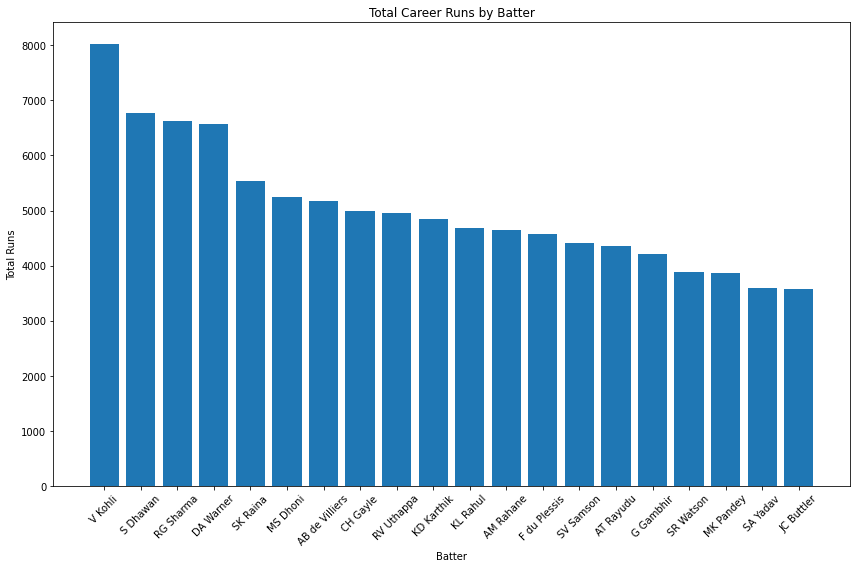

In [0]:
# Visualizing using Matplotlib
career_runs_pd = career_runs_df.toPandas()[0:20]

plt.figure(figsize=(12, 8))
plt.bar(career_runs_pd["striker"], career_runs_pd["Total Runs"])
plt.xlabel('Batter')
plt.ylabel('Total Runs')
plt.title('Total Career Runs by Batter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
#Total Career Wickets by Bowler

career_wickets_df = ball_by_ball_df.filter(("wicket_type != 'retired hurt' and wicket_type != 'retired out' and wicket_type != 'run out'  and wicket_type != 'null' and wicket_type != 'obstructing the field'")).groupby("bowler").agg(count("wicket_type").alias("Total Wickets")).orderBy("Total Wickets", ascending = False)

career_wickets_df.show(5)

+---------+-------------+
|   bowler|Total Wickets|
+---------+-------------+
|YS Chahal|          205|
|PP Chawla|          192|
| DJ Bravo|          183|
|  B Kumar|          181|
|SP Narine|          180|
+---------+-------------+
only showing top 5 rows



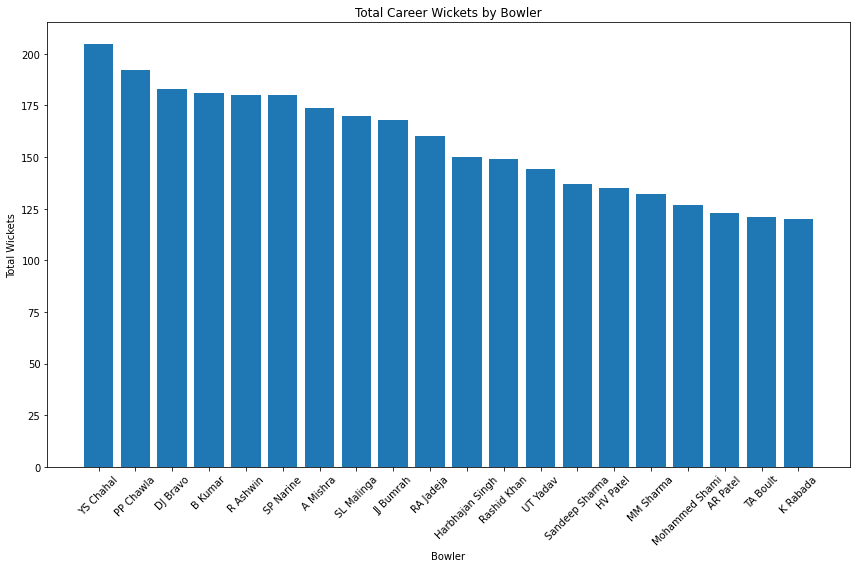

In [0]:
# Visualizing using Matplotlib
career_wickets_pd = career_wickets_df.toPandas()[0:20]

plt.figure(figsize=(12, 8))
plt.bar(career_wickets_pd["bowler"], career_wickets_pd["Total Wickets"])
plt.xlabel('Bowler')
plt.ylabel('Total Wickets')
plt.title('Total Career Wickets by Bowler')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
#Most extras given

bowler_extras_df = ball_by_ball_df.groupby("bowler").agg(sum(col("wides")+col("noballs")).alias("Total Extras"),
                                      sum(col("wides")).alias("Total Wides"),
                                      sum(col("noballs")).alias("Total No-balls")) \
                                      .orderBy("Total Extras", ascending = False)
                                      
bowler_extras_df.show(5)

+----------+------------+-----------+--------------+
|    bowler|Total Extras|Total Wides|Total No-balls|
+----------+------------+-----------+--------------+
|  R Ashwin|         191|        187|             4|
|   B Kumar|         185|        173|            12|
|  DJ Bravo|         182|        173|             9|
|SL Malinga|         172|        152|            20|
|  I Sharma|         152|        129|            23|
+----------+------------+-----------+--------------+
only showing top 5 rows



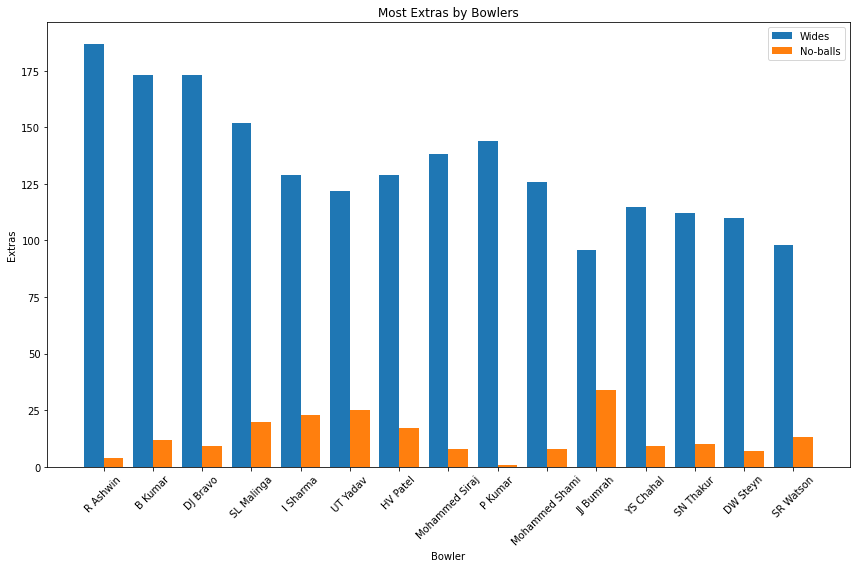

In [0]:
# Visualizing using Matplotlib
bowler_extras_pd = bowler_extras_df.toPandas()[0:15]

x_axis = np.arange(len(bowler_extras_pd))

plt.figure(figsize=(12, 8))
plt.bar(x_axis - 0.2, bowler_extras_pd["Total Wides"], 0.4, label = 'Wides')
plt.bar(x_axis + 0.2, bowler_extras_pd["Total No-balls"], 0.4, label = 'No-balls')
plt.xticks(x_axis, bowler_extras_pd["bowler"], rotation=45)
plt.xlabel('Bowler')
plt.ylabel('Extras')
plt.title('Most Extras by Bowlers')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
#most runs in each season 

max_runs_per_striker = ball_by_ball_df.groupby("season","striker").agg(sum("runs_off_bat").alias("Total Runs"))

window_spec = Window.partitionBy("season").orderBy(col("Total Runs").desc())

max_runs_per_season = max_runs_per_striker.withColumn("rank", row_number().over(window_spec)) \
                                          .filter(col("rank") == 1) \
                                          .drop("rank")

max_runs_per_season.show()

+------+-------------+----------+
|season|      striker|Total Runs|
+------+-------------+----------+
|  2008|     SE Marsh|       616|
|  2009|    ML Hayden|       572|
|  2010| SR Tendulkar|       618|
|  2011|     CH Gayle|       608|
|  2012|     CH Gayle|       733|
|  2013|   MEK Hussey|       733|
|  2014|   RV Uthappa|       660|
|  2015|    DA Warner|       562|
|  2016|      V Kohli|       973|
|  2017|    DA Warner|       641|
|  2018|KS Williamson|       735|
|  2019|    DA Warner|       692|
|  2020|     KL Rahul|       676|
|  2021|   RD Gaikwad|       635|
|  2022|   JC Buttler|       863|
|  2023| Shubman Gill|       890|
|  2024|      V Kohli|       741|
+------+-------------+----------+



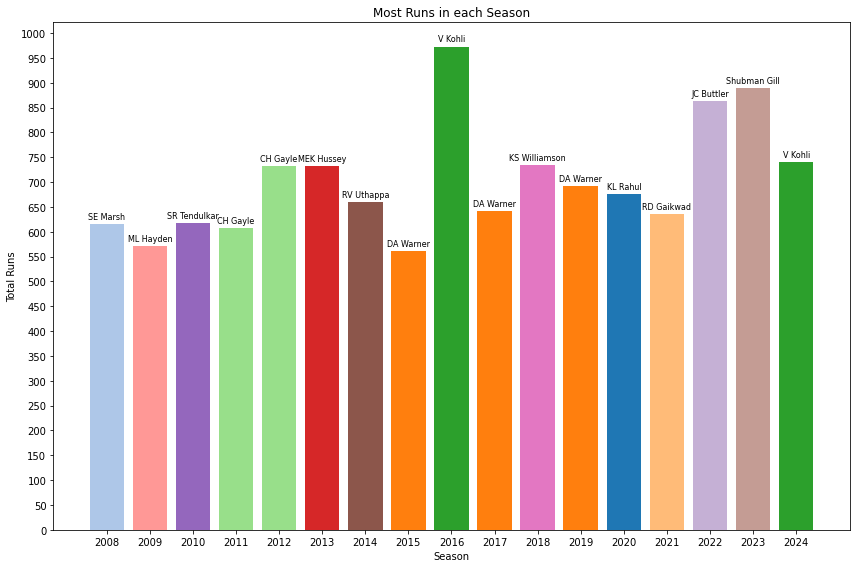

In [0]:
# Visualizing using Matplotlib
max_runs_per_season_pd = max_runs_per_season.toPandas()

x_axis = np.arange(len(max_runs_per_season_pd))

# Create a color map to assign a unique color to each unique label
unique_labels = list(set(max_runs_per_season_pd["striker"]))
colors = plt.get_cmap('tab20')  # Use a colormap with different colors

# Map each label to a unique color
label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

# Plot the bars with the same color for recurring labels
bar_colors = [label_to_color[label] for label in max_runs_per_season_pd["striker"]]

plt.figure(figsize=(12, 8))
plt.bar(x_axis, max_runs_per_season_pd["Total Runs"], 0.8, color=bar_colors)
plt.xticks(x_axis, max_runs_per_season_pd["season"])
plt.yticks(np.arange(0, 1050, 50))  
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.title('Most Runs in each Season')
for i in range(len(max_runs_per_season_pd)):
        plt.text(i, max_runs_per_season_pd["Total Runs"].iloc[i] + 10, max_runs_per_season_pd["striker"].iloc[i], 
                 ha = 'center', fontsize = 8)
plt.tight_layout()
plt.show()


In [0]:
#most wickets in each season 

max_wickets_per_bowler = ball_by_ball_df.filter(("wicket_type != 'retired hurt' and wicket_type != 'retired out' and wicket_type != 'run out'  and wicket_type != 'null' and wicket_type != 'obstructing the field'")).groupby("season","bowler").agg(count("wicket_type").alias("Total Wickets")).orderBy("Total Wickets")

window_spec = Window.partitionBy("season").orderBy(col("Total Wickets").desc())

max_wickets_per_season = max_wickets_per_bowler.withColumn("rank", row_number().over(window_spec)) \
                                          .filter(col("rank") == 1) \
                                          .drop("rank")

max_wickets_per_season.show()

+------+--------------+-------------+
|season|        bowler|Total Wickets|
+------+--------------+-------------+
|  2008| Sohail Tanvir|           22|
|  2009|      RP Singh|           23|
|  2010|       PP Ojha|           21|
|  2011|    SL Malinga|           28|
|  2012|      M Morkel|           25|
|  2013|      DJ Bravo|           32|
|  2014|     MM Sharma|           23|
|  2015|      DJ Bravo|           26|
|  2016|       B Kumar|           23|
|  2017|       B Kumar|           26|
|  2018|        AJ Tye|           24|
|  2019|      K Rabada|           26|
|  2020|      K Rabada|           32|
|  2021|      HV Patel|           32|
|  2022|     YS Chahal|           27|
|  2023|Mohammed Shami|           28|
|  2024|      HV Patel|           24|
+------+--------------+-------------+



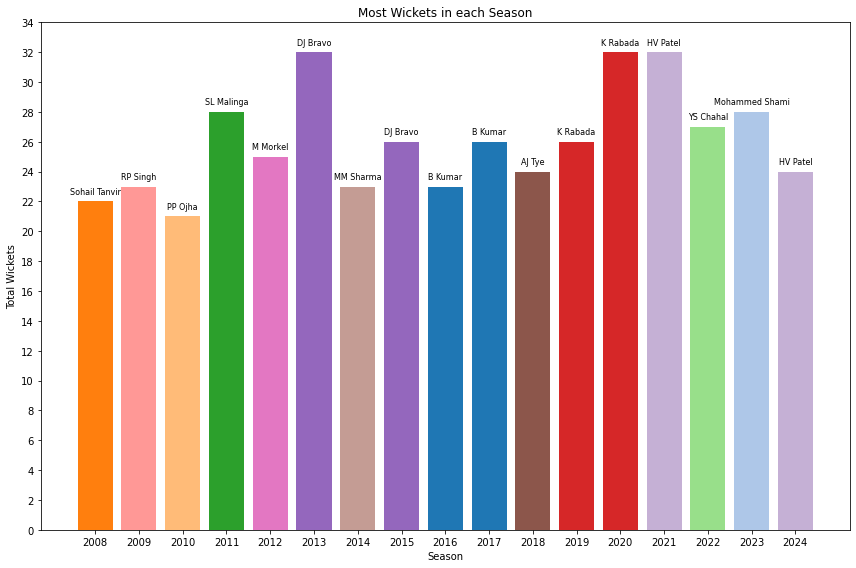

In [0]:
# Visualizing using Matplotlib
max_wickets_per_season_pd = max_wickets_per_season.toPandas()

x_axis = np.arange(len(max_wickets_per_season_pd))

# Create a color map to assign a unique color to each unique label
unique_labels = list(set(max_wickets_per_season_pd["bowler"]))
colors = plt.get_cmap('tab20')  # Use a colormap with different colors

# Map each label to a unique color
label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

# Plot the bars with the same color for recurring labels
bar_colors = [label_to_color[label] for label in max_wickets_per_season_pd["bowler"]]

plt.figure(figsize=(12, 8))
plt.bar(x_axis, max_wickets_per_season_pd["Total Wickets"], 0.8, color=bar_colors)
plt.xticks(x_axis, max_wickets_per_season_pd["season"])
plt.yticks(np.arange(0, 35, 2))  
plt.xlabel('Season')
plt.ylabel('Total Wickets')
plt.title('Most Wickets in each Season')
for i in range(len(max_wickets_per_season_pd)):
        plt.text(i, max_wickets_per_season_pd["Total Wickets"].iloc[i] + 0.5, max_wickets_per_season_pd["bowler"].iloc[i], ha = 'center', fontsize = 8)
plt.tight_layout()
plt.show()


In [0]:
#Batsmen with most deliveries at non-striker end

non_striker_balls = ball_by_ball_df.groupby("non_striker").agg(count("ball").alias("Total Deliveries")).orderBy("Total Deliveries", ascending = False)

non_striker_balls.show(5)

+-----------+----------------+
|non_striker|Total Deliveries|
+-----------+----------------+
|    V Kohli|            6067|
|   S Dhawan|            5942|
|  RG Sharma|            5271|
|  DA Warner|            4677|
|   SK Raina|            4309|
+-----------+----------------+
only showing top 5 rows



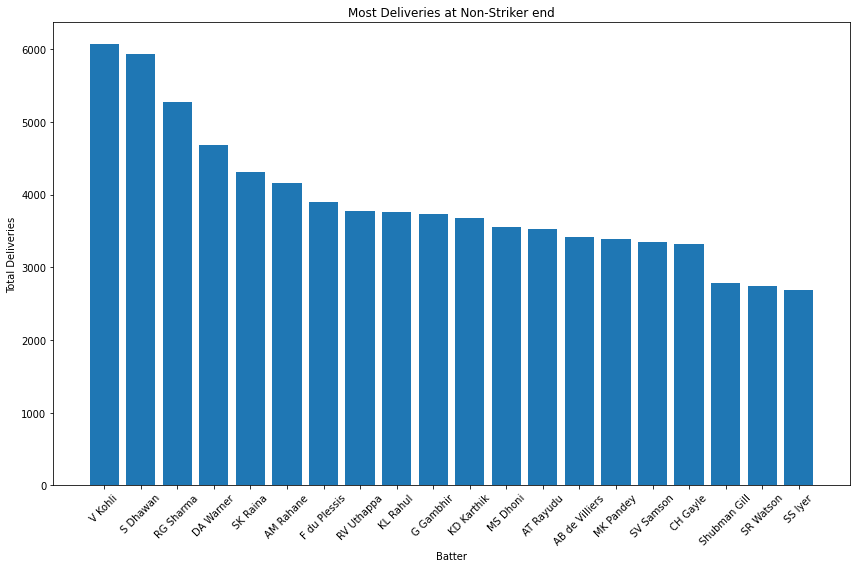

In [0]:
# Visualizing using Matplotlib
non_striker_balls_pd = non_striker_balls.toPandas()[0:20]

plt.figure(figsize=(12, 8))
plt.bar(non_striker_balls_pd["non_striker"], non_striker_balls_pd["Total Deliveries"])
plt.xlabel('Batter')
plt.ylabel('Total Deliveries')
plt.title('Most Deliveries at Non-Striker end')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
# most matches by players without any contribution

match_contributors_df = ball_by_ball_df \
.select("match_id",col("batting_team").alias("team"),col("striker").alias("player")) \
.union(ball_by_ball_df.select("match_id",col("batting_team").alias("team"),col("non_striker").alias("player"))) \
.union(ball_by_ball_df.select("match_id",col("bowling_team").alias("team"),col("bowler").alias("player"))) \
.distinct()

non_contributors_df = match_players_df.join(
                      match_contributors_df,
                      ["match_id","team","player"],
                      "left_anti")

non_contributors_df = non_contributors_df.groupBy("player").agg(count("match_id").alias("Total Matches")).orderBy("Total Matches", ascending = False)

non_contributors_df.show(10)

+-----------+-------------+
|     player|Total Matches|
+-----------+-------------+
|   MS Dhoni|           34|
|S Badrinath|           27|
|    WP Saha|           24|
| KD Karthik|           23|
|    NV Ojha|           19|
|  SS Tiwary|           19|
|   M Manhas|           17|
|   DJ Hooda|           17|
|  AT Rayudu|           17|
|  R Tewatia|           14|
+-----------+-------------+
only showing top 10 rows



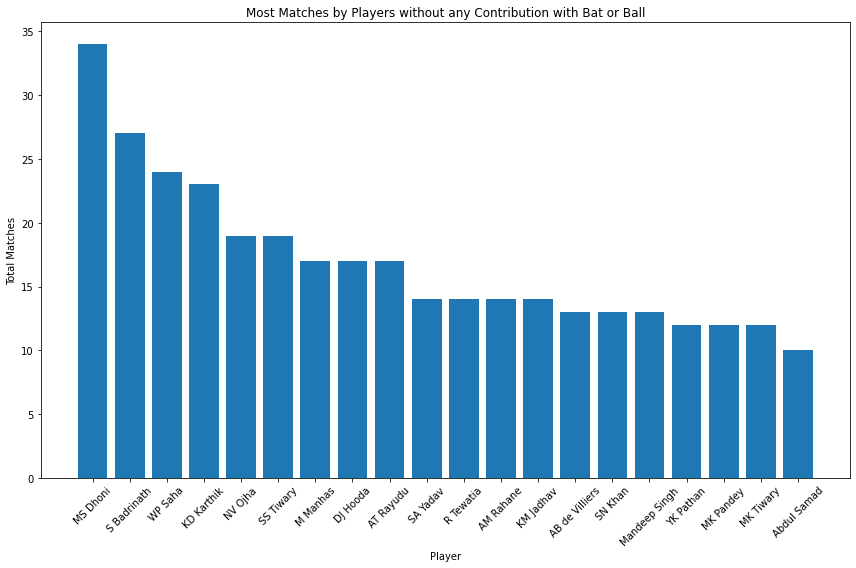

In [0]:
# Visualizing using Matplotlib
non_contributors_pd = non_contributors_df.toPandas()[0:20]

plt.figure(figsize=(12, 8))
plt.bar(non_contributors_pd["player"], non_contributors_pd["Total Matches"])
plt.xlabel('Player')
plt.ylabel('Total Matches')
plt.title('Most Matches by Players without any Contribution with Bat or Ball')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
# most matches by venue
venue_count_df = match_info_df.groupBy("venue").agg(count("match_id").alias("Total Matches")).orderBy("Total Matches", ascending = False)

venue_count_df.show(100, truncate = False)

+------------------------------------------------------------------+-------------+
|venue                                                             |Total Matches|
+------------------------------------------------------------------+-------------+
|Wankhede Stadium                                                  |118          |
|M Chinnaswamy Stadium                                             |94           |
|Eden Gardens                                                      |93           |
|Feroz Shah Kotla                                                  |90           |
|MA Chidambaram Stadium                                            |85           |
|Rajiv Gandhi International Stadium                                |77           |
|Punjab Cricket Association IS Bindra Stadium                      |61           |
|Sawai Mansingh Stadium                                            |57           |
|Maharashtra Cricket Association Stadium                           |51           |
|Dub

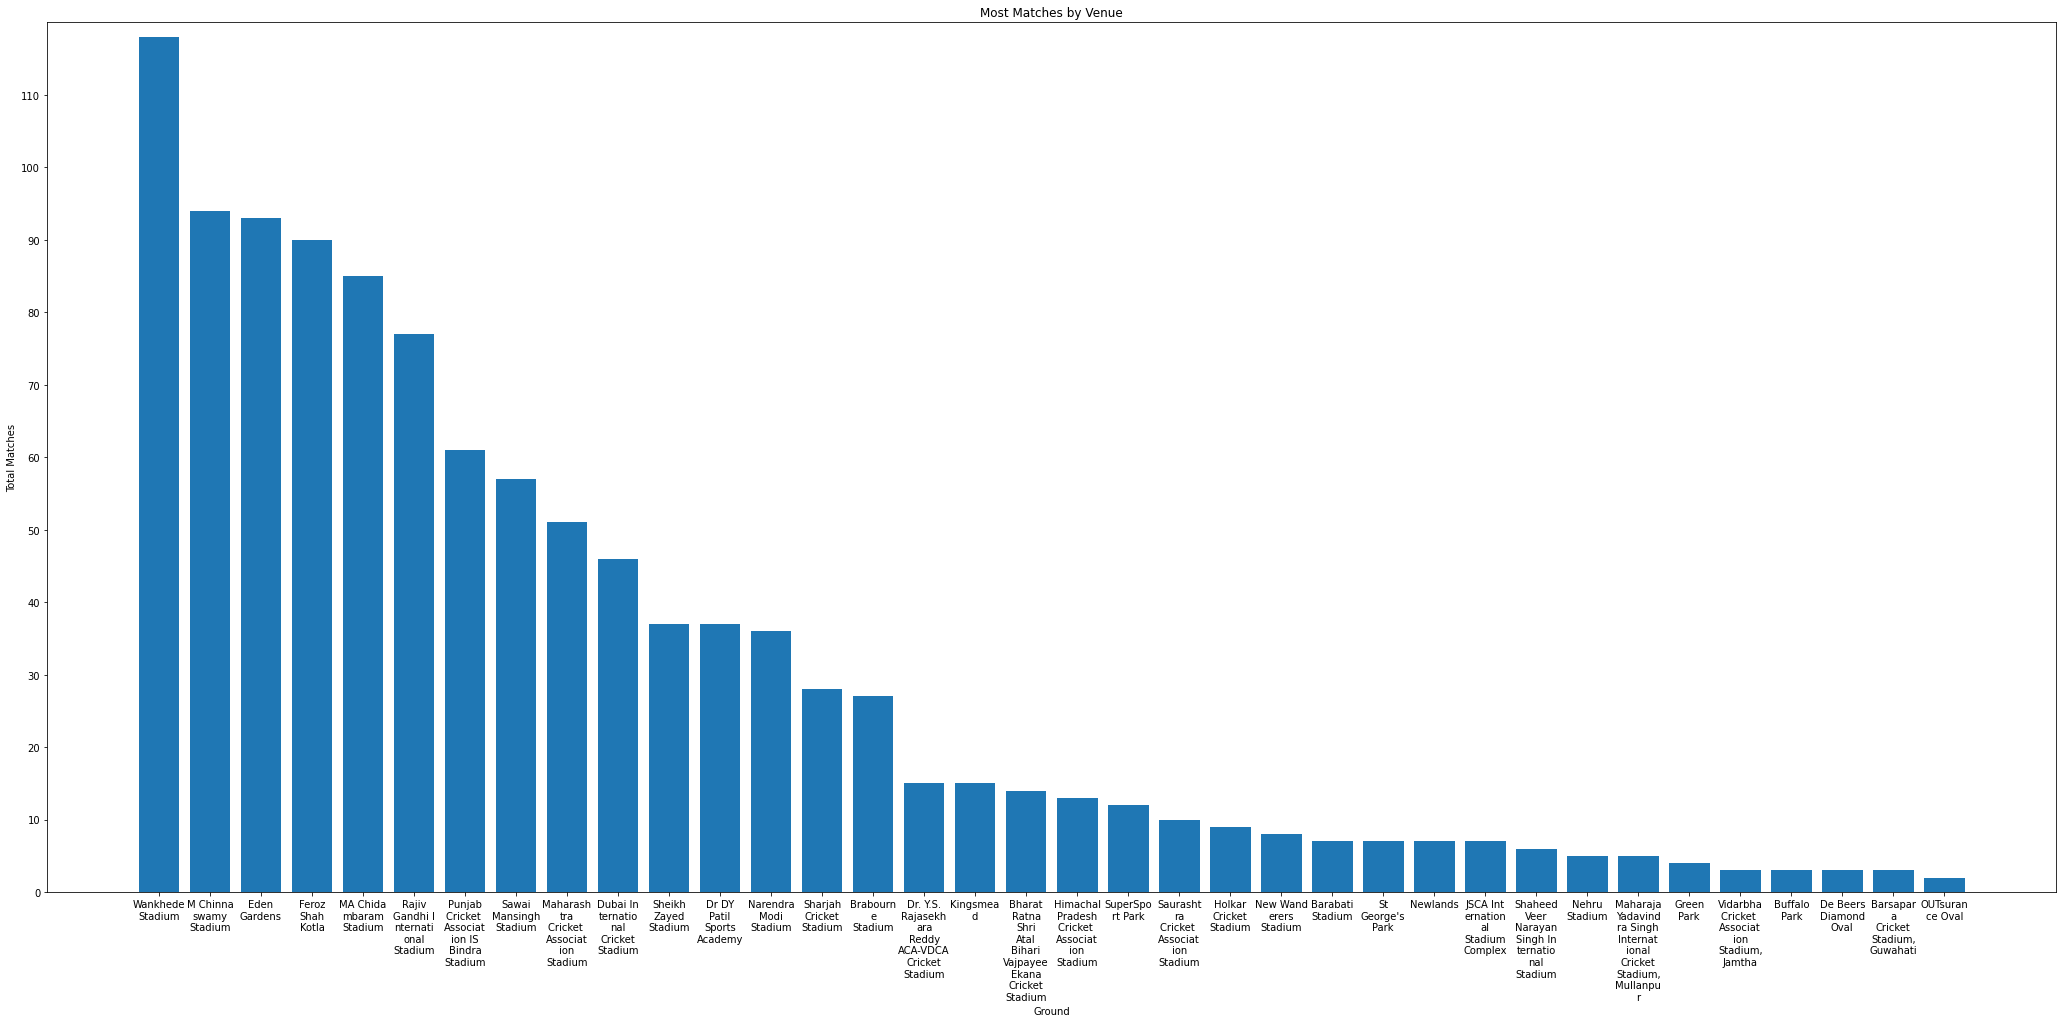

In [0]:
# Visualizing using Matplotlib
venue_count_pd = venue_count_df.toPandas()

x_axis = np.arange(len(venue_count_pd))

# Custom labels with wrapping
labels = venue_count_pd["venue"]
wrapped_labels = [textwrap.fill(label, 8) for label in labels] 

plt.figure(figsize=(36, 16))
plt.bar(venue_count_pd["venue"], venue_count_pd["Total Matches"])
plt.xlabel('Ground')
plt.ylabel('Total Matches')
plt.title('Most Matches by Venue')
plt.xticks(x_axis, wrapped_labels)
plt.yticks(np.arange(0, 120, 10))
plt.ylim(0, 120)
plt.show()


In [0]:
# average 1st innings score by season
innings_score_df = ball_by_ball_df.filter(col("innings").isin(1)).groupBy("season","match_id").agg(max("running_total_runs").alias("score"))

average_season_score_df = innings_score_df.groupBy("season").agg(format_number(avg("score"),0).alias("Avg 1st innings Score")).orderBy("season")

average_season_score_df.show()

+------+---------------------+
|season|Avg 1st innings Score|
+------+---------------------+
|  2008|                  161|
|  2009|                  150|
|  2010|                  165|
|  2011|                  152|
|  2012|                  158|
|  2013|                  156|
|  2014|                  163|
|  2015|                  166|
|  2016|                  163|
|  2017|                  166|
|  2018|                  172|
|  2019|                  167|
|  2020|                  170|
|  2021|                  159|
|  2022|                  171|
|  2023|                  183|
|  2024|                  190|
+------+---------------------+



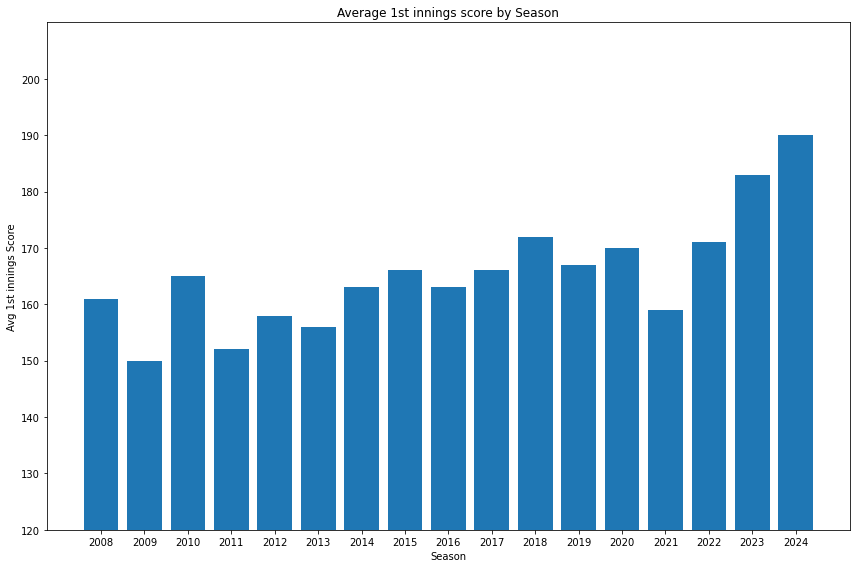

In [0]:
# Visualizing using Matplotlib
average_season_score_pd = average_season_score_df.toPandas()

x_axis = np.arange(len(average_season_score_pd))

plt.figure(figsize=(12, 8))
plt.bar(x_axis, average_season_score_pd["Avg 1st innings Score"].astype(int), 0.8)
plt.xticks(x_axis, average_season_score_pd["season"])
plt.yticks(np.arange(0, 210, 10))
plt.ylim(120, 210)
plt.xlabel('Season')
plt.ylabel('Avg 1st innings Score')
plt.title('Average 1st innings score by Season')
plt.tight_layout()
plt.show()


In [0]:
# average 1st innings score by venue

venue_score_df = ball_by_ball_df.filter(col("innings").isin(1)).groupBy("venue","match_id").agg(max("running_total_runs").alias("score"))

average_venue_score_df = venue_score_df.groupBy("venue").agg(format_number(avg("score"),0).alias("Avg 1st innings Score")).orderBy("Avg 1st innings Score", ascending = False)

average_venue_score_df.show(100, truncate = False)

+------------------------------------------------------------------+---------------------+
|venue                                                             |Avg 1st innings Score|
+------------------------------------------------------------------+---------------------+
|Himachal Pradesh Cricket Association Stadium                      |184                  |
|Barsapara Cricket Stadium, Guwahati                               |180                  |
|Brabourne Stadium                                                 |179                  |
|M Chinnaswamy Stadium                                             |173                  |
|Narendra Modi Stadium                                             |172                  |
|Wankhede Stadium                                                  |170                  |
|Feroz Shah Kotla                                                  |169                  |
|Saurashtra Cricket Association Stadium                            |169                  |

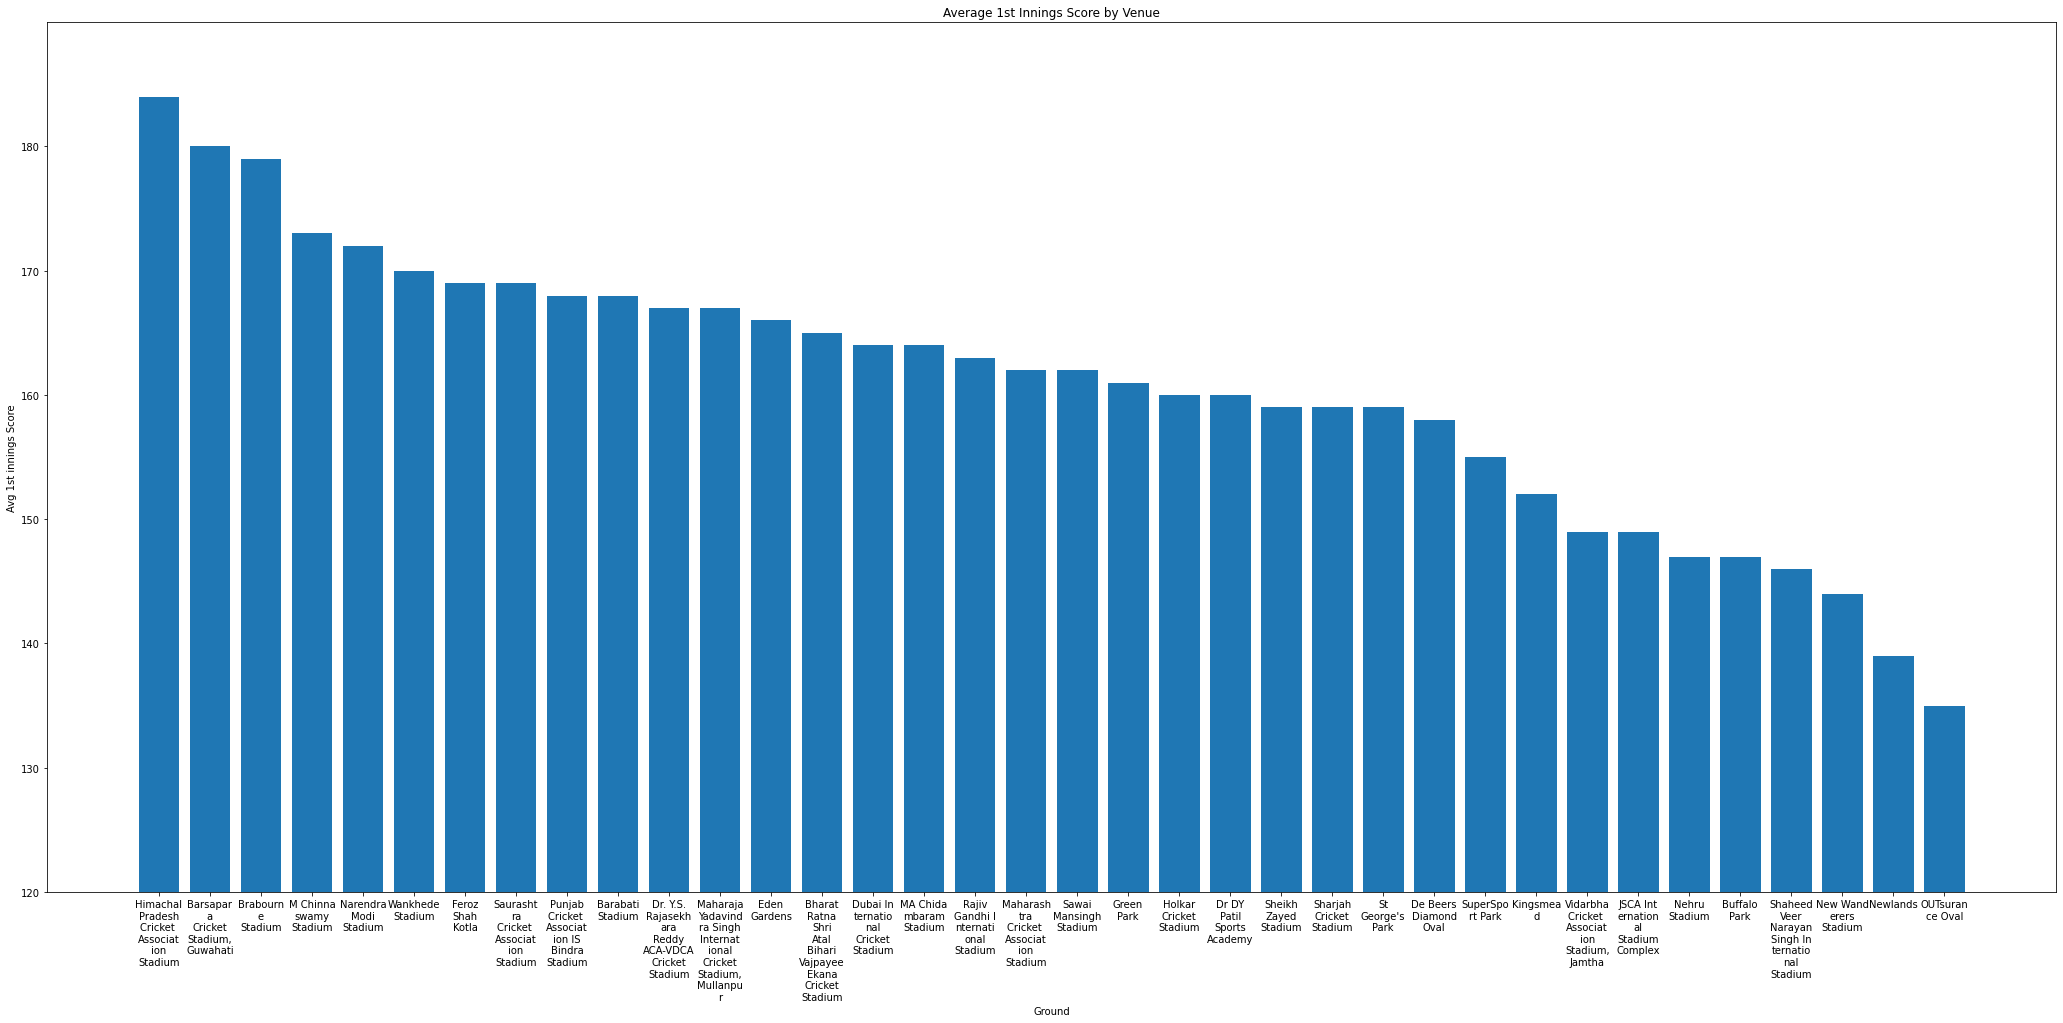

In [0]:
# Visualizing using Matplotlib
average_venue_score_pd = average_venue_score_df.toPandas()

x_axis = np.arange(len(average_venue_score_pd))

# Custom labels with wrapping
labels = average_venue_score_pd["venue"]
wrapped_labels = [textwrap.fill(label, 8) for label in labels] 

plt.figure(figsize=(36, 16))
plt.bar(average_venue_score_pd["venue"], average_venue_score_pd["Avg 1st innings Score"].astype(int))
plt.xlabel('Ground')
plt.ylabel('Avg 1st innings Score')
plt.title('Average 1st Innings Score by Venue')
plt.xticks(x_axis, wrapped_labels)
plt.yticks(np.arange(0, 190, 10))
plt.ylim(120, 190)
plt.show()


In [0]:
# win-loss records on winning toss

toss_record_df = match_info_df.select("match_id","toss_winner","winner") \
             .withColumn("toss_wins_match",when(col("toss_winner") == col("winner"), "Win").otherwise("Loss")) 
             
toss_record_df = toss_record_df.groupBy("toss_wins_match").agg(count("match_id").alias("Count"))

toss_record_df.show()

+---------------+-----+
|toss_wins_match|Count|
+---------------+-----+
|            Win|  548|
|           Loss|  547|
+---------------+-----+



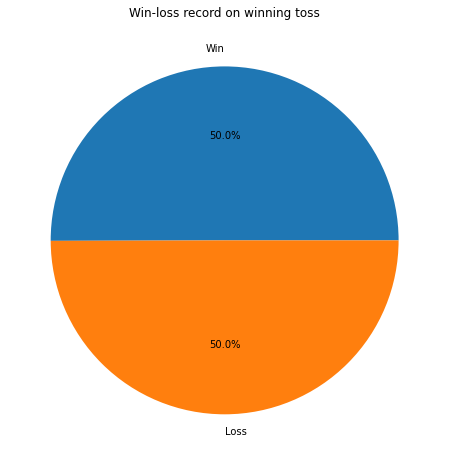

In [0]:
# Visualizing using Matplotlib
toss_record_pd = toss_record_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(toss_record_pd["Count"], labels = toss_record_pd["toss_wins_match"], autopct='%.1f%%')
plt.title('Win-loss record on winning toss')
plt.show()


In [0]:
# win-loss record on batting 1st & 2nd

win_record_df = match_info_df.select("match_id","winner_runs","winner_wickets") \
             .withColumn("wins_match",when(col("winner_runs").isNotNull(), "batting 1st").otherwise("other")) \
             .withColumn("wins_match",when(col("winner_wickets").isNotNull(), "batting 2nd").otherwise(col("wins_match")))
             
win_record_df = win_record_df.groupBy("wins_match").agg(count("match_id").alias("Count"))

win_record_df.show()


+-----------+-----+
| wins_match|Count|
+-----------+-----+
|batting 2nd|  578|
|      other|   19|
|batting 1st|  498|
+-----------+-----+



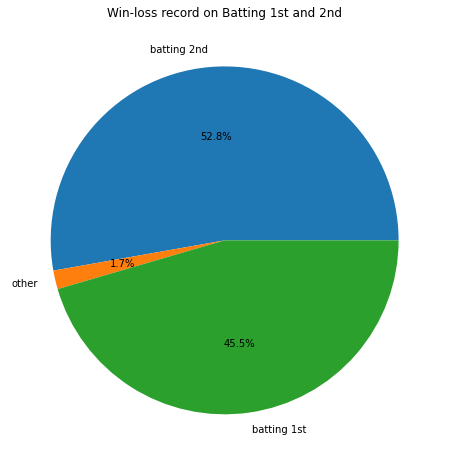

In [0]:
# Visualizing using Matplotlib
win_record_pd = win_record_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(win_record_pd["Count"], labels = win_record_pd["wins_match"], autopct='%.1f%%')
plt.title('Win-loss record on Batting 1st and 2nd')
plt.show()


In [0]:
# average run rate in each phase of game by season

powerplay_df = ball_by_ball_df.filter(col("over").between(0,5)).groupBy("season").agg(format_number((avg("runs_scored") * 6), 2).alias("powerplay")).orderBy("season")

middle_overs_df = ball_by_ball_df.filter(col("over").between(6,14)).groupBy("season").agg(format_number((avg("runs_scored") * 6), 2).alias("middle_overs")).orderBy("season")

death_overs_df = ball_by_ball_df.filter(col("over").between(15,19)).groupBy("season").agg(format_number((avg("runs_scored") * 6), 2).alias("death_overs")).orderBy("season")


combined_df = powerplay_df \
    .join(middle_overs_df, on="season", how="inner") \
    .join(death_overs_df, on="season", how="inner").orderBy("season")

combined_df.show()

+------+---------+------------+-----------+
|season|powerplay|middle_overs|death_overs|
+------+---------+------------+-----------+
|  2008|     7.33|        7.72|       9.56|
|  2009|     6.88|        6.67|       8.76|
|  2010|     7.51|        7.33|       9.21|
|  2011|     6.91|        7.24|       8.74|
|  2012|     6.97|        7.20|       9.17|
|  2013|     6.73|        7.07|       9.22|
|  2014|     7.26|        7.58|       9.62|
|  2015|     7.45|        7.61|       9.86|
|  2016|     7.43|        7.65|       9.69|
|  2017|     8.04|        7.67|       9.22|
|  2018|     8.17|        7.84|       9.62|
|  2019|     7.94|        7.51|       9.66|
|  2020|     7.44|        7.48|       9.78|
|  2021|     7.49|        7.36|       8.87|
|  2022|     7.54|        7.79|       9.76|
|  2023|     8.39|        8.18|       9.81|
|  2024|     9.09|        8.49|      10.37|
+------+---------+------------+-----------+



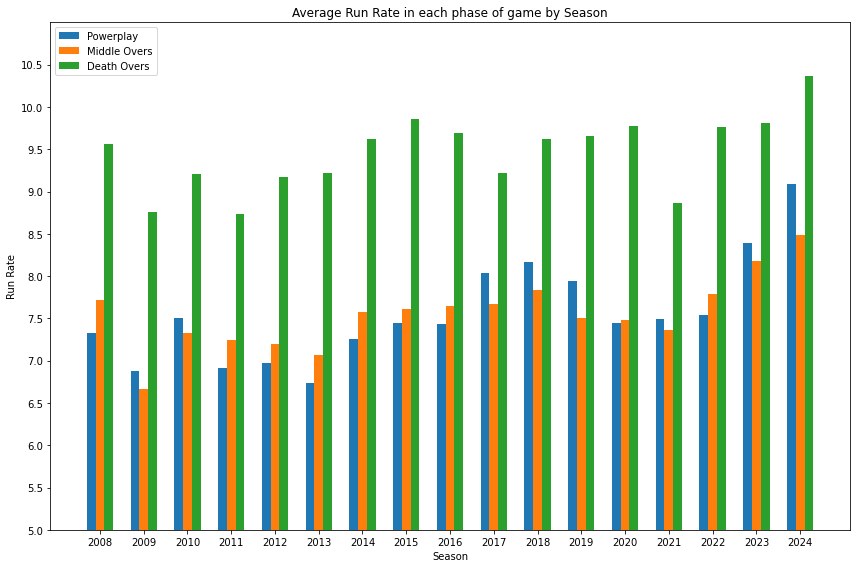

In [0]:
# Visualizing using Matplotlib
combined_pd = combined_df.toPandas()

x_axis = np.arange(len(average_season_score_pd))

plt.figure(figsize=(12, 8))
plt.bar(x_axis - 0.2, combined_pd["powerplay"].astype(float), 0.2, label = 'Powerplay')
plt.bar(x_axis, combined_pd["middle_overs"].astype(float), 0.2, label = 'Middle Overs')
plt.bar(x_axis + 0.2, combined_pd["death_overs"].astype(float), 0.2, label = 'Death Overs')
plt.xticks(x_axis, combined_pd["season"])
plt.yticks(np.arange(0, 11, 0.5))  
plt.ylim(5, 11)
plt.xlabel('Season')
plt.ylabel('Run Rate')
plt.title('Average Run Rate in each phase of game by Season')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

Spark SQL Examples -->

In [0]:
# Creating Temp views to use SQL queries on data

match_info_df.createOrReplaceTempView("match_info")
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")

In [0]:
# win-loss records by team

result_by_team = spark.sql(
    """
    WITH all_teams AS (
        SELECT match_id, team_1 AS team, winner FROM match_info
        UNION ALL
        SELECT match_id, team_2 AS team, winner FROM match_info
    )
    SELECT 
    team,
    SUM(CASE WHEN winner = team THEN 1 ELSE 0 END) AS wins,
    SUM(CASE WHEN winner != team THEN 1 ELSE 0 END) AS losses
    FROM all_teams
    GROUP BY team
    ORDER BY wins DESC
    """
)

result_by_team.show(truncate = False)

+---------------------------+----+------+
|team                       |wins|losses|
+---------------------------+----+------+
|Mumbai Indians             |142 |115   |
|Chennai Super Kings        |138 |98    |
|Kolkata Knight Riders      |130 |117   |
|Royal Challengers Bengaluru|121 |128   |
|Rajasthan Royals           |110 |106   |
|Sunrisers Hyderabad        |87  |91    |
|Kings XI Punjab            |85  |101   |
|Delhi Daredevils           |67  |91    |
|Delhi Capitals             |45  |43    |
|Deccan Chargers            |29  |46    |
|Gujarat Titans             |28  |17    |
|Lucknow Super Giants       |24  |19    |
|Punjab Kings               |24  |32    |
|Rising Pune Supergiant     |15  |15    |
|Gujarat Lions              |13  |16    |
|Pune Warriors              |12  |33    |
|Kochi Tuskers Kerala       |6   |8     |
+---------------------------+----+------+



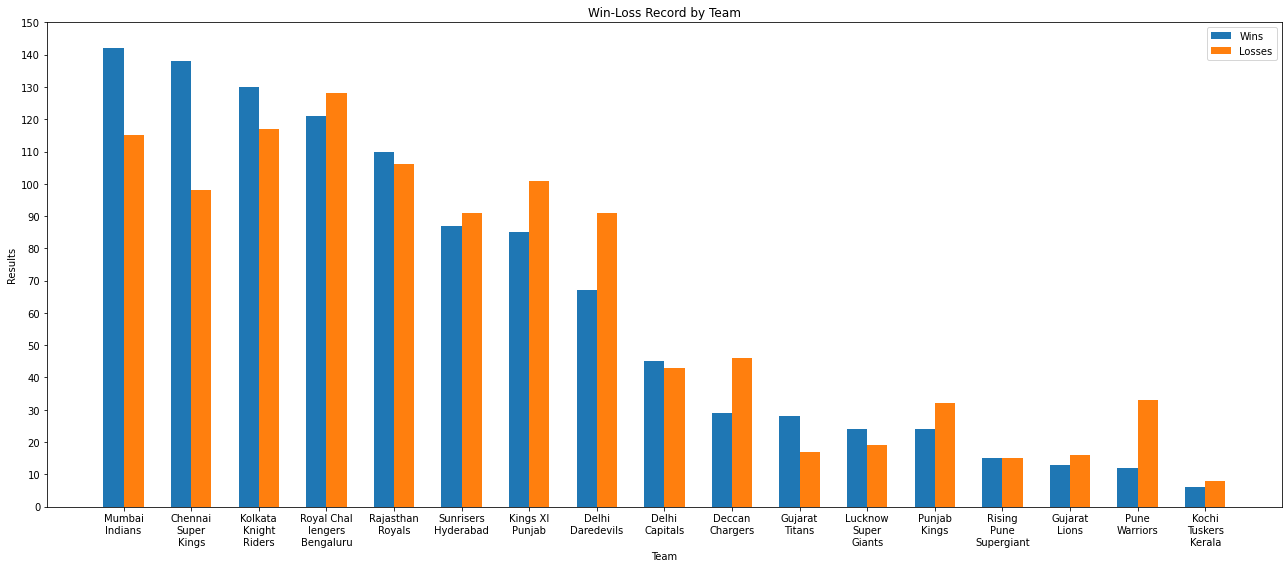

In [0]:
# Visualizing using Matplotlib
result_by_team_pd = result_by_team.toPandas()

x_axis = np.arange(len(result_by_team_pd))

# Custom labels with wrapping
labels = result_by_team_pd["team"]
wrapped_labels = [textwrap.fill(label, 10) for label in labels] 

plt.figure(figsize=(18, 8))
plt.bar(x_axis - 0.15, result_by_team_pd["wins"], 0.3, label = 'Wins')
plt.bar(x_axis + 0.15, result_by_team_pd["losses"], 0.3, label = 'Losses')
plt.xticks(x_axis, wrapped_labels)
plt.yticks(np.arange(0, 160, 10))  
plt.xlabel('Team')
plt.ylabel('Results')
plt.title('Win-Loss Record by Team')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
# average run rate in each phase of game by venue

venue_run_rate = spark.sql(
    """
    SELECT 
        venue,
        FORMAT_NUMBER(AVG(CASE WHEN `over` BETWEEN 0 and 5 THEN runs_scored END) * 6, 2) AS powerplay,
        FORMAT_NUMBER(AVG(CASE WHEN `over` BETWEEN 6 and 14 THEN runs_scored END) * 6, 2) AS middle_overs,
        FORMAT_NUMBER(AVG(CASE WHEN `over` BETWEEN 15 and 19 THEN runs_scored END) * 6, 2) AS death_overs
    FROM ball_by_ball
    GROUP BY venue
    ORDER BY venue
    """
)

venue_run_rate.show(100, truncate = False)

+------------------------------------------------------------------+---------+------------+-----------+
|venue                                                             |powerplay|middle_overs|death_overs|
+------------------------------------------------------------------+---------+------------+-----------+
|Barabati Stadium                                                  |7.02     |7.60        |10.29      |
|Barsapara Cricket Stadium, Guwahati                               |8.04     |7.60        |9.80       |
|Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium      |7.80     |7.28        |9.02       |
|Brabourne Stadium                                                 |8.33     |8.02        |9.87       |
|Buffalo Park                                                      |6.13     |5.89        |9.40       |
|De Beers Diamond Oval                                             |6.43     |6.87        |9.73       |
|Dr DY Patil Sports Academy                                     

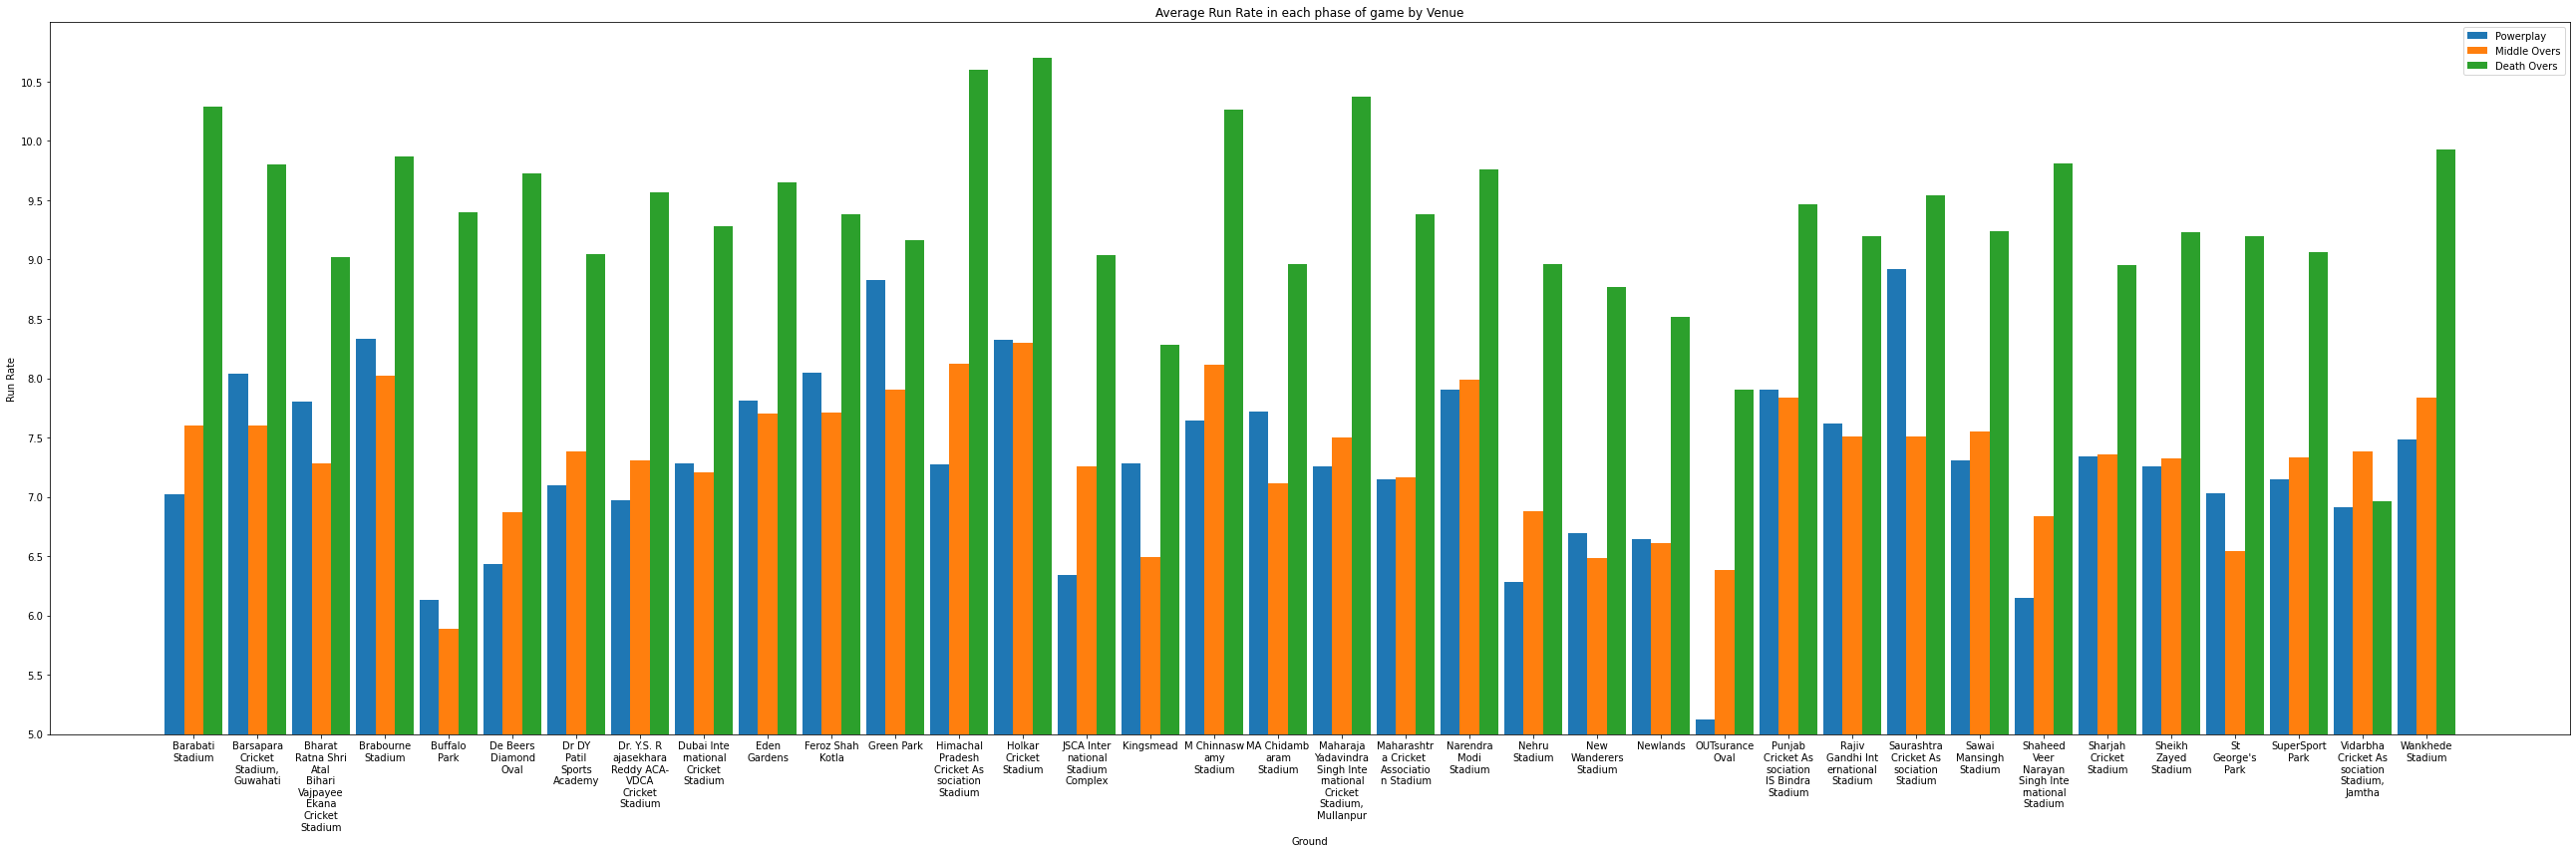

In [0]:
# Visualizing using Matplotlib
venue_run_rate_pd = venue_run_rate.toPandas()

x_axis = np.arange(len(venue_run_rate_pd))

# Custom labels with wrapping
labels = venue_run_rate_pd["venue"]
wrapped_labels = [textwrap.fill(label, 10) for label in labels] 

plt.figure(figsize=(36, 12))
plt.bar(x_axis - 0.3, venue_run_rate_pd["powerplay"].astype(float), 0.3, label = 'Powerplay')
plt.bar(x_axis, venue_run_rate_pd["middle_overs"].astype(float), 0.3, label = 'Middle Overs')
plt.bar(x_axis + 0.3, venue_run_rate_pd["death_overs"].astype(float), 0.3, label = 'Death Overs')
plt.xticks(x_axis, wrapped_labels)
plt.yticks(np.arange(0, 11, 0.5))  
plt.ylim(5, 11)
plt.xlabel('Ground')
plt.ylabel('Run Rate')
plt.title('Average Run Rate in each phase of game by Venue')
plt.legend()
plt.tight_layout()
plt.show()